# Simulating a magnet using a Monte Carlo algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1- Generate starting configuration

We start with a randomly generated array of magnetic moments \\( \{ \vec{m}_1, \vec{m}_2, \dots, \vec{m}_n \} \\). The length of each moment is fixed \\( |\vec{m}_i| = 1 \\) but the orientation is chosen randomly. We can construct this by generating a random polar angle \\( \varphi_i \\) and azimutal angle \\( \theta_i \\) and using spherical coordinates:

\\( \vec{m}_i = \begin{pmatrix} \cos\varphi_i\sin\theta_i \\ \sin\varphi_i\sin\theta_i \\ \cos\theta_i \end{pmatrix} \\)

### Magnetic moments

In [2]:
length = 40
num = length**2

rand_phi = 2*np.pi * np.random.rand(num).reshape(length, length, 1)
rand_theta = np.pi * np.random.rand(num).reshape(length, length, 1)

In [3]:
mag = np.array([np.cos(rand_phi)*np.sin(rand_theta), np.sin(rand_phi)*np.sin(rand_theta), np.cos(rand_theta)])

In [4]:
mag[:,5,2,0]

array([-0.68806029,  0.47787303, -0.54608645])

In [5]:
# check norm
np.sqrt(mag[0,:]**2 + mag[1,:]**2 + mag[2,:]**2)[5,2,0]

1.0

### Positions

In [6]:
coords = np.array(np.meshgrid(np.arange(length),
                              np.arange(length),
                              np.arange(1)))

### Plot

In [7]:
# Change standard size of all figures in this notebook
plt.rcParams['figure.figsize'] = [40, 15]

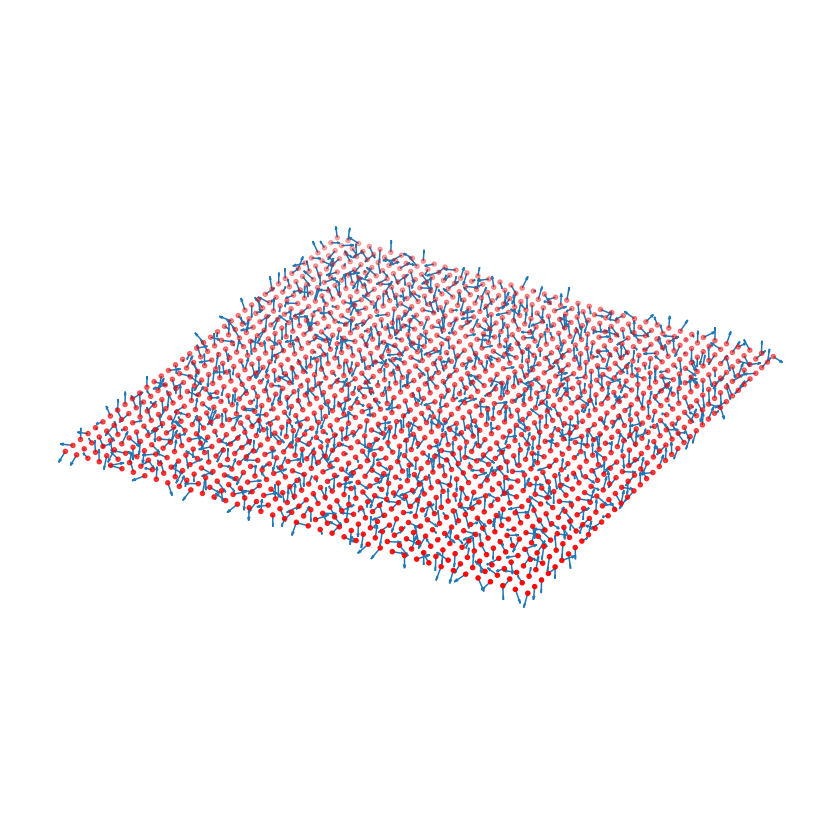

In [8]:
arrowplot = plt.axes(projection='3d')
arrowplot.set_zlim(-1,1)
arrowplot.set_box_aspect(aspect=(length, length, 2))

# make background invisible
arrowplot.axis(False)

# Quiver plot
arrowplot.quiver(
    coords[0], coords[1], coords[2],
    mag[0], mag[1], mag[2])

# Coordinate plot
arrowplot.scatter3D(coords[0], coords[1], coords[2], color='red')

## 2- Calculating the energy 

We are searching for the configuration with the lowest energy. For a ferromagnet the energy can be written as:

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j  \\) 

Every moment is interacting with its direct neighbor (\\( <i,j> \\)) and prefers a parallel orientation as long as \\( J > 0\\). Of course, there exist additional energy terms that have to be considered for a realistic ferromagnet but we will neglect them for now. 

In [9]:
J = 1

In [10]:
def energy_exchange_contribution(mag, x, y):
    return -0.5 * J * np.dot(mag[:,x,y,0],
                             mag[:,(x+1)%length,y,0] + mag[:,(x-1)%length,y,0]\
                             + mag[:,x,(y+1)%length,0] + mag[:,x,(y-1)%length,0])

def energy_exchange(mag):
    # mag: Array magnetic moments
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energy_exchange_contribution(mag, x, y)
    return energy

In [11]:
energy_exchange(mag)

-23.575723084442725

__Update 1:__ We can apply an external magnetic field \\( \vec{B} \\). This leads to the energy:

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu \sum_i \vec{B}\cdot \vec{m}_i \\) 

In [12]:
mu = 1
B = np.array([0,0,0])

def energy_magnetic_contribution(mag, x, y):
    return -mu * np.dot(B, mag[:,x,y,0])

def energy_magnetic(mag):
    # mag: Array magnetic moments
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energy_magnetic_contribution(mag, x, y)
    return energy

__Update 2:__ We include the Dzyaloshinskii–Moriya interaction (asymmetric exchange).

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu B \sum_i m_i^{(z)}  + \frac{1}{2}\sum_{<i,j>}\vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right)\\) 

The vectors \\( \vec{D}_{ij} \\) are determined by the symmetry of the sample. In our example, they shall point along the direction \\( i \rightarrow j\\). 

As an example, let us consider a bond along the \\( x \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_x \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(y)}m_j^{(z)} - m_i^{(z)}m_j^{(y)} \right)\\) 

For a bond along the \\( y \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_y \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(z)}m_j^{(x)} - m_i^{(x)}m_j^{(z)} \right)\\) 

In [13]:
D = 0.3
def energy_dmi_contribution(mag,x,y):
    right = mag[1,x,y,0]*mag[2,(x+1)%length,y,0] - mag[2,x,y,0]*mag[1,(x+1)%length,y,0]
    left = -mag[1,x,y,0]*mag[2,(x-1)%length,y,0] + mag[2,x,y,0]*mag[1,(x-1)%length,y,0]
    up = mag[2,x,y,0]*mag[0,x,(y+1)%length,0] - mag[0,x,y,0]*mag[2,x,(y+1)%length,0]
    down = -mag[2,x,y,0]*mag[0,x,(y-1)%length,0] + mag[0,x,y,0]*mag[2,x,(y-1)%length,0]
    return 0.5 * D * (right + left + up + down)

def energy_dmi(mag):
    # mag: Array magnetic field
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energy_dmi_contribution(mag, x, y)
    return energy

## 3- Metropolis step

In [14]:
def step_exchange(mag):
    # 1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energy_old = 2 * energy_exchange_contribution(mag, x, y)
    # 2.
    rand_phi = 2*np.random.rand()
    rand_theta = np.random.rand()
    save_mag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([np.cos(rand_phi)*np.sin(rand_theta), np.sin(rand_phi)*np.sin(rand_theta), np.cos(rand_theta)])
    # 3.
    energy_new = 2 * energy_exchange_contribution(mag, x, y)
    # 4.
    if (energy_new < energy_old):
        # accept the change & update the energy
        energy_change = energy_new - energy_old
    else:
        # decline & restore old moment
        mag[:,x,y,0] = save_mag
        energy_change = 0
    return [mag, energy_change]

In [15]:
step_exchange(mag)[1]

0

__Update 1:__ For finite temperatures \\( T \\), we accept the change with a chance \\( \exp\left(-\frac{E_\mathrm{new}-E_\mathrm{old}}{k_BT}\right) \\)

In [16]:
def step_exchange_t(mag, kBtemp):
    # 1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energy_old = 2 * energy_exchange_contribution(mag, x, y)
    # 2.
    rand_phi = 2*np.pi * np.random.rand()
    rand_theta = np.pi * np.random.rand()
    save_mag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([np.cos(rand_phi)*np.sin(rand_theta), np.sin(rand_phi)*np.sin(rand_theta), np.cos(rand_theta)])
    # 3.
    energy_new = 2 * energy_exchange_contribution(mag, x, y)
    # 4.
    if (energy_new < energy_old):
        # accept the change & update the energy
        energy_change = energy_new - energy_old
    else:
        if np.random.rand() < np.exp(-(energy_new - energy_old) / kBtemp):
            # accept the change & update the energy
            energy_change = energy_new - energy_old
        else:
            # decline & restore old moment
            mag[:,x,y,0] = save_mag
            energy_change = 0
    return [mag, energy_change]

__Update 2:__ We include the energy corresponding to the interaction with the magnetic field:

__Update 3:__ We include the energy corresponding to the Dzyaloshinskii–Moriya interaction (asymmetric exchange):

In [17]:
def step_t(mag, kBtemp):
    # 1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energy_old = 2 * energy_exchange_contribution(mag, x, y) + energy_magnetic_contribution(mag, x, y)\
                + 2 * energy_dmi_contribution(mag, x, y)
    # 2.
    rand_phi = 2*np.pi * np.random.rand()
    rand_theta = np.pi * np.random.rand()
    save_mag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([np.cos(rand_phi)*np.sin(rand_theta), np.sin(rand_phi)*np.sin(rand_theta), np.cos(rand_theta)])
    # 3.
    energy_new = 2 * energy_exchange_contribution(mag, x, y)+ energy_magnetic_contribution(mag, x, y)\
                + 2 * energy_dmi_contribution(mag, x, y)
    # 4.
    if (energy_new < energy_old):
        # accept the change & update the energy
        energy_change = energy_new - energy_old
    else:
        if np.random.rand() < np.exp(-(energy_new - energy_old) / kBtemp):
            # accept the change & update the energy
            energy_change = energy_new - energy_old
        else:
            # decline & restore old moment
            mag[:,x,y,0] = save_mag
            energy_change = 0
    return [mag, energy_change]

## 4- Run the Monte Carlo algorithm

In [18]:
number_steps = 10000000

#optional
#energy = energy_exchange(mag)
energy = energy_exchange(mag) + energy_magnetic(mag) + energy_dmi(mag)
energy_list = [energy]

for i in range(number_steps):
    # mag, energy_change = step_exchange(mag)  # Initial version: zero temperature
    kBtemp = 0.2*(1-i/number_steps)
    # mag, energy_change = step_exchange_t(mag, kBtemp)  # Update 1: Consider finite temperatures
    mag, energy_change = step_t(mag, kBtemp)
    #optional
    energy = energy + energy_change
    energy_list.append(energy)

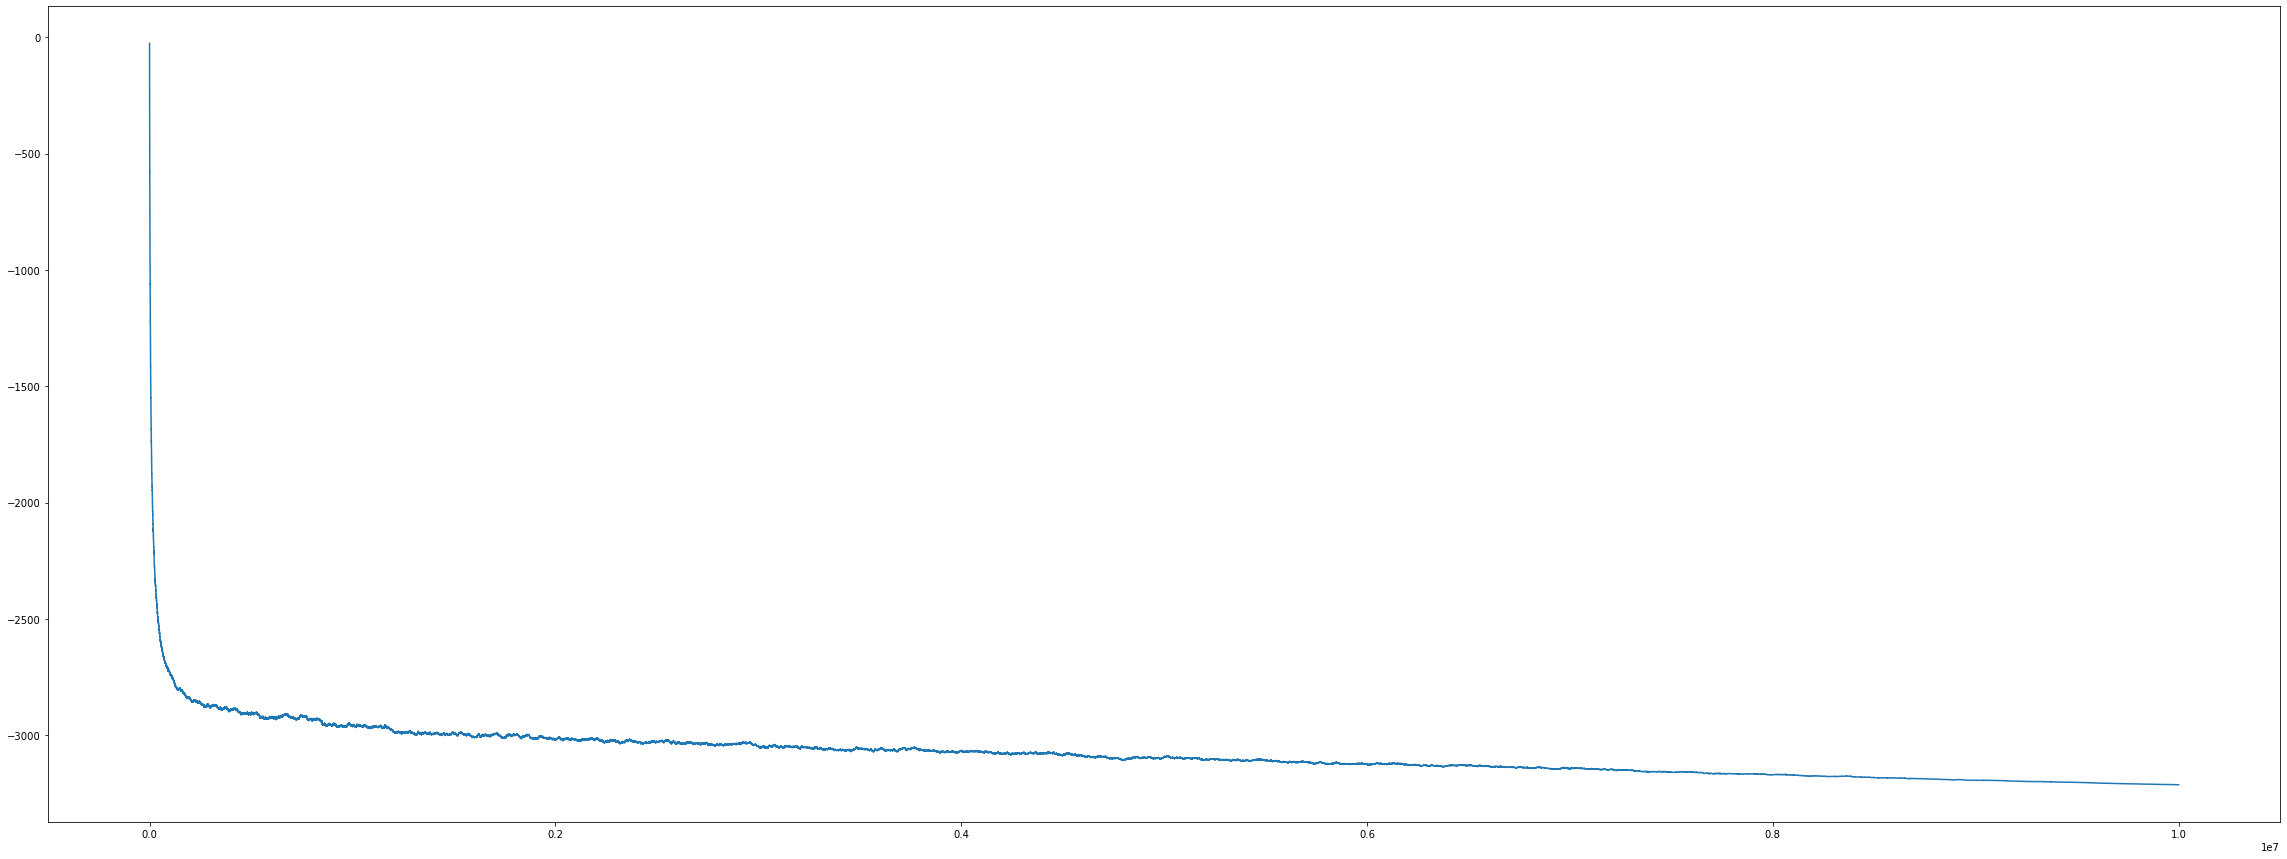

In [19]:
plt.plot(range(number_steps+1), energy_list)

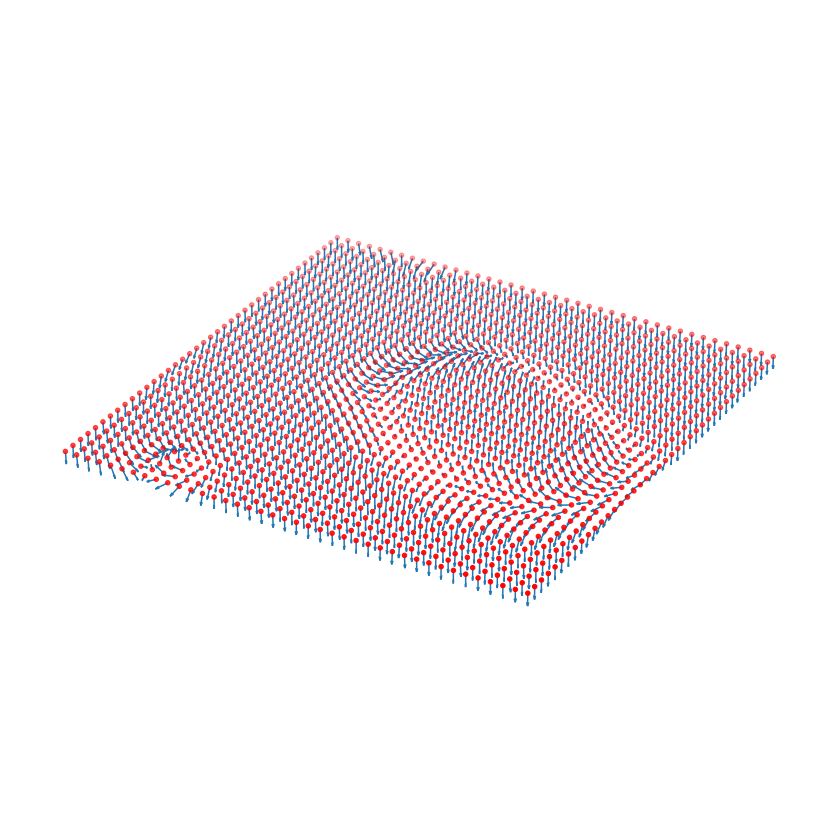

In [20]:
arrowplot = plt.axes(projection='3d')
arrowplot.set_zlim(-1,1)
arrowplot.set_box_aspect(aspect=(length, length, 2))

# make background invisible
arrowplot.axis(False)

# Quiver plot
arrowplot.quiver(
    coords[0], coords[1], coords[2],
    mag[0], mag[1], mag[2])

# Coordinate plot
arrowplot.scatter3D(coords[0], coords[1], coords[2], color='red')

In [21]:
energy_list[-1]

-3212.850270199078

In [22]:
energy_exchange(mag)

-3142.3502874738824